In [1]:
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.svm import LinearSVR
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./flight_delay.csv')
print(data)

       Depature Airport Scheduled depature time Destination Airport  \
0                   SVO     2015-10-27 07:40:00                 HAV   
1                   SVO     2015-10-27 09:50:00                 JFK   
2                   SVO     2015-10-27 10:45:00                 MIA   
3                   SVO     2015-10-27 12:30:00                 LAX   
4                   OTP     2015-10-27 14:15:00                 SVO   
...                 ...                     ...                 ...   
675508              SVO     2018-08-31 23:50:00                 SVX   
675509              LED     2018-08-31 23:50:00                 SVO   
675510              SVO     2018-08-31 23:55:00                 EGO   
675511              SVO     2018-08-31 23:55:00                 TSE   
675512              SVO     2018-08-31 17:25:00                 IKT   

       Scheduled arrival time  Delay  
0         2015-10-27 20:45:00    0.0  
1         2015-10-27 20:35:00    2.0  
2         2015-10-27 23:35:00 

In [3]:
# Initial dataset division into significant features and labels (Delay and Year - train / test data label)

Delay = np.array(data['Delay'])
Duration = np.array([(datetime.fromisoformat(data['Scheduled arrival time'][i]) - \
    datetime.fromisoformat(data['Scheduled depature time'][i])).seconds / 60 
    for i in range(len(data['Scheduled depature time']))])
Month = np.array([datetime.fromisoformat(data['Scheduled depature time'][i]).month 
    for i in range(len(data['Scheduled depature time']))])
Path = np.array(data['Depature Airport'] + data['Destination Airport'])
Year = np.array([0 if datetime.fromisoformat(data['Scheduled depature time'][i]).year < 2018 else 1 
    for i in range(len(data['Scheduled depature time']))])

In [4]:
# Encoding of Path feature (from string to int format)

p_lecd = LabelEncoder()
p_lecd.fit(Path)
Path = p_lecd.transform(Path)

In [5]:
# Creation of key features variables

Features = np.concatenate((np.array([Year]).transpose(), np.array([Path]).transpose(), np.array([Month]).transpose(), 
    np.array([Duration]).transpose()), axis = 1)
Labels = np.concatenate((np.array([Year]).transpose(), np.array([Delay]).transpose()), axis = 1)
month = np.concatenate((np.array([Year]).transpose(), np.array([Month]).transpose()), axis = 1)
path = np.concatenate((np.array([Year]).transpose(), np.array([Path]).transpose()), axis = 1)

In [6]:
# Division of the chosen data into train and test by year labels (0 for train and 1 for test)
# Year column is not transplaced into test and train datasets

f_train = Features[np.array(np.where(Features[:, 0] == 0))[0], 1:]
f_test = Features[np.array(np.where(Features[:, 0] == 1))[0], 1:]
l_train = Labels[np.array(np.where(Labels[:, 0] == 0))[0], 1:]
l_test = Labels[np.array(np.where(Labels[:, 0] == 1))[0], 1:]
m_train = month[np.array(np.where(month[:, 0] == 0))[0], 1:]
m_test = month[np.array(np.where(month[:, 0] == 1))[0], 1:]
p_train = path[np.array(np.where(path[:, 0] == 0))[0], 1:]
p_test = path[np.array(np.where(path[:, 0] == 1))[0], 1:]

In [7]:
# Concatenation of features and labels datasets in terms to identify the similar rows of data

unq_dt = np.concatenate((f_train, l_train), axis = 1)

In [8]:
# Rewriting of train and test datasets with unique rows only

init_lgth = len(f_train)
unq_dt, idx = np.unique(unq_dt, axis = 0, return_index = True)
f_train = f_train[idx]
l_train = l_train[idx]
m_train = m_train[idx]
p_train = p_train[idx]
print(str(int(len(f_train) / init_lgth * 100)) + '% of data are unique')

26% of data are unique


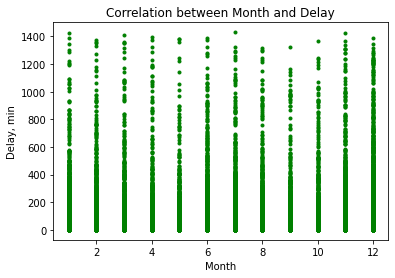

In [9]:
# Representation of relationship between month feature and delay labels

plt.plot(m_train, l_train, '.', color = "green")
plt.title("Correlation between Month and Delay")
plt.xlabel("Month")
plt.ylabel("Delay, min")
plt.show()

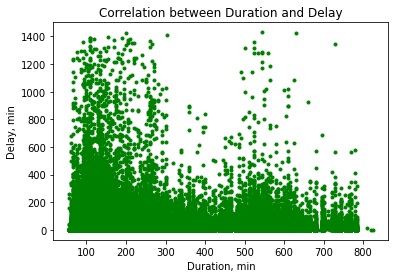

In [10]:
# Representation of relationship between duration feature and delay labels

plt.plot(f_train[:, -1], l_train, '.', color = "green")
plt.title("Correlation between Duration and Delay")
plt.xlabel("Duration, min")
plt.ylabel("Delay, min")
plt.show()

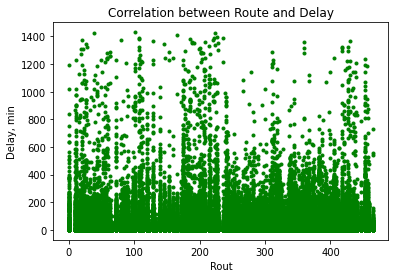

In [11]:
# Representation of relationship between path feature and delay labels

plt.plot(p_train, l_train, '.', color = "green")
plt.title("Correlation between Route and Delay")
plt.xlabel("Rout")
plt.ylabel("Delay, min")
plt.show()

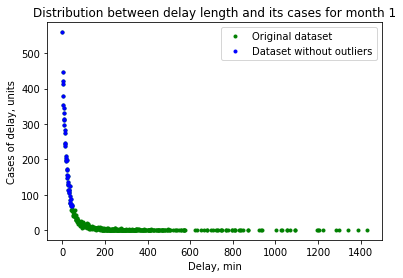

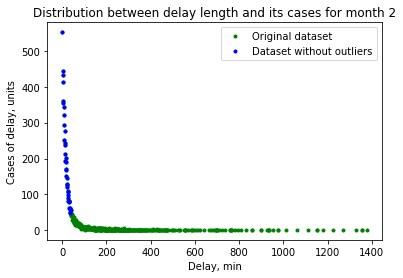

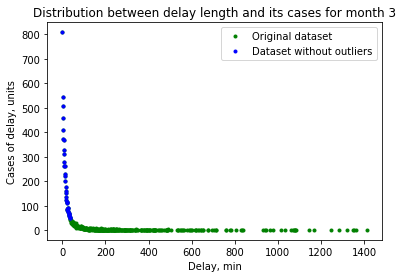

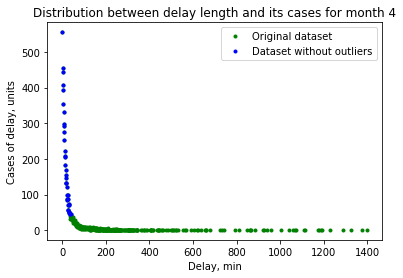

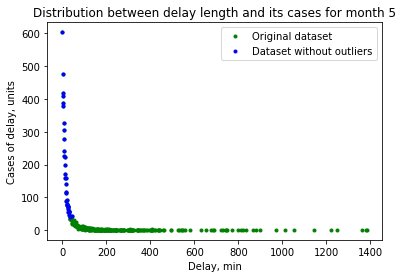

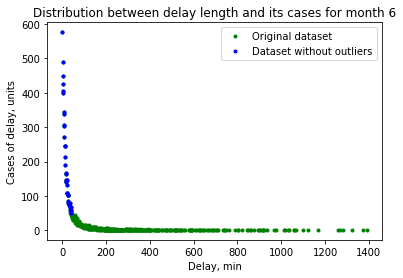

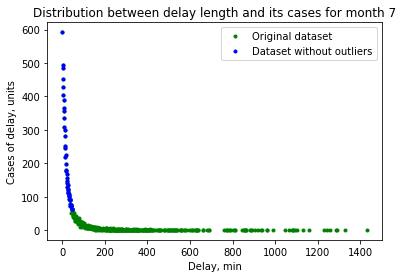

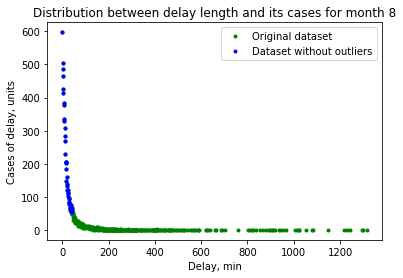

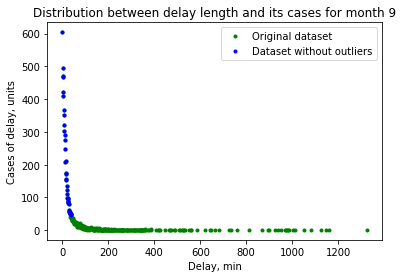

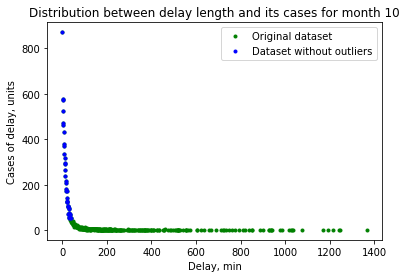

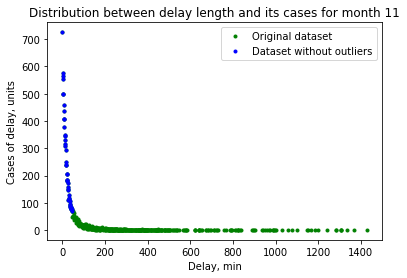

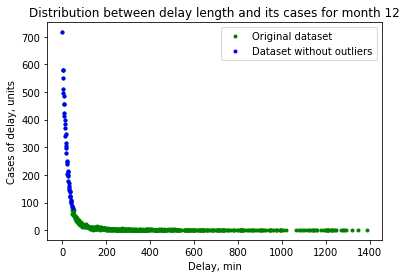

In [12]:
# Removal of outliers with respect to month-delay dataset structure

m_idxs = np.array([])
for i in list(set(m_train[:, 0])): # Choose i-th month
    delay, m_idx = l_train[np.where(m_train[:, 0] == i), :][0], np.where(m_train[:, 0] == i)
    delay = np.concatenate((delay, np.array(np.where(m_train[:, 0] == i)).transpose()), axis = 1)
    delays = []
    for j in list(set(delay[:, 0])):
        delays.append([j, np.count_nonzero(delay[:, 0] == j)]) # And count every delay frequency
    delays = np.array(delays)
    idx = np.where(delays[:, 1] / delays[:, 1].sum() > 0.005) # If the current delay's frequency with respect to the whole 
                                                               # amount of delays (even 0) is bigger, than the set threshold,
    plt.plot(delays[:, 0], delays[:, 1], '.', color = "green") # then the current delay is not an outlier
    plt.plot(delays[idx, 0], delays[idx, 1], '.', color = "blue")
    plt.title("Distribution between delay length and its cases for month " + str(i))
    plt.xlabel("Delay, min")
    plt.ylabel("Cases of delay, units")
    plt.legend(['Original dataset', 'Dataset without outliers'])
    plt.show()
    
    idxs = []
    for j in range(len(delay[:, 0])):
        if delay[j, 0] in delays[idx, 0][0]:
            idxs.append(j)
    m_idx = np.array(delay[idxs, 1], dtype = int)
    m_idxs = np.concatenate((m_idxs, m_idx), axis = 0) # Creation of a dataset of non-outlier indices

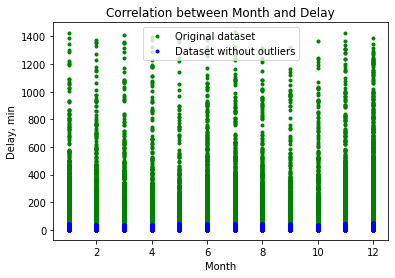

In [13]:
# Plot the dataset without outliers with respect to the initial dataset for month feature

plt.plot(m_train, l_train, '.', color = "green")
plt.plot(m_train[np.array(m_idxs, dtype = int)], l_train[np.array(m_idxs, dtype = int)], '.', color = "blue")
plt.title("Correlation between Month and Delay")
plt.xlabel("Month")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers'])
plt.show()

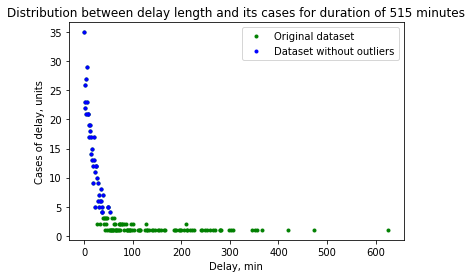

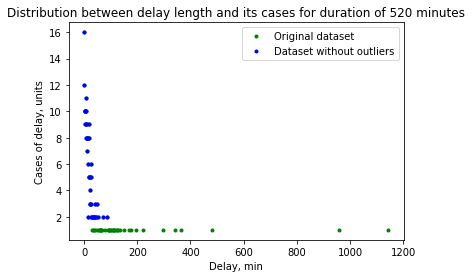

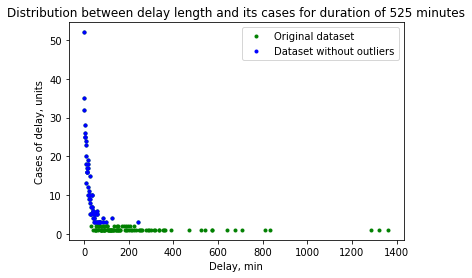

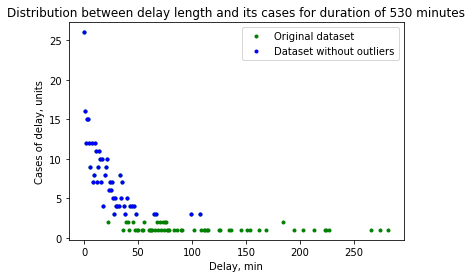

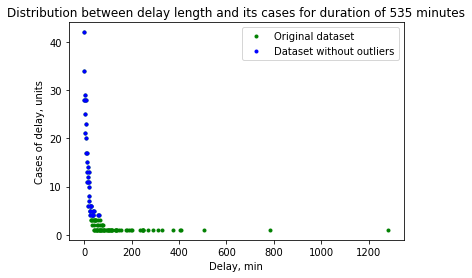

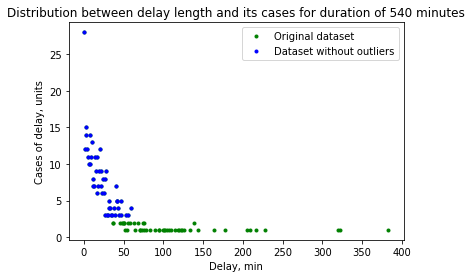

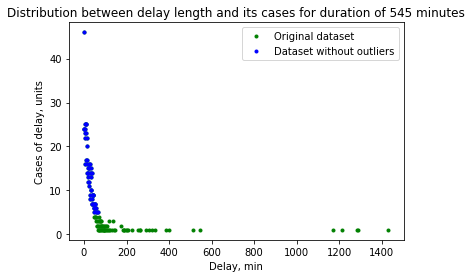

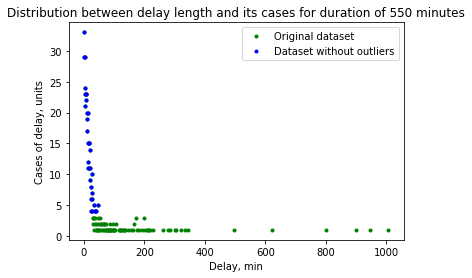

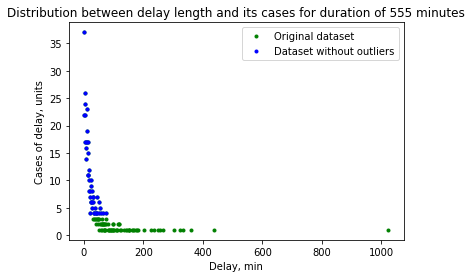

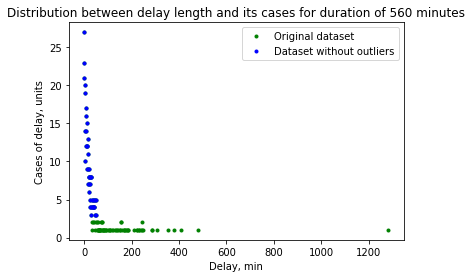

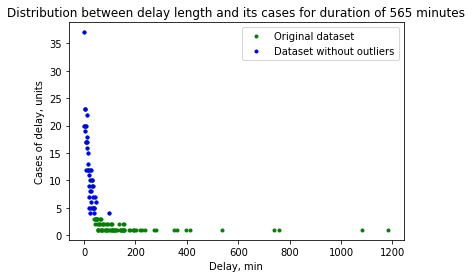

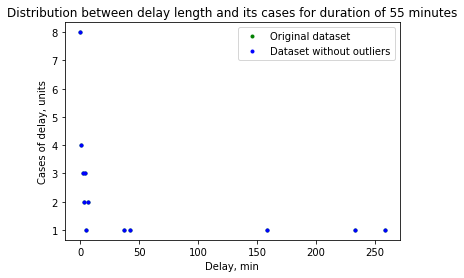

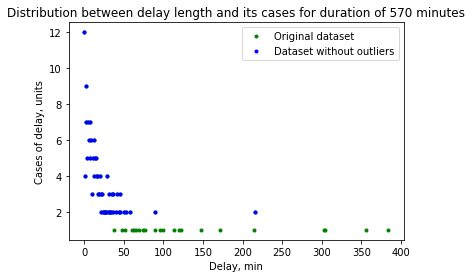

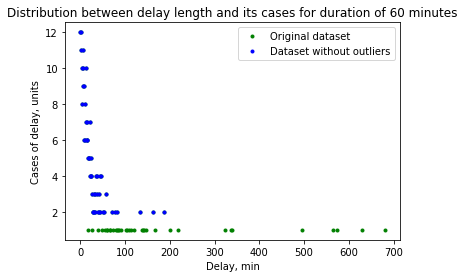

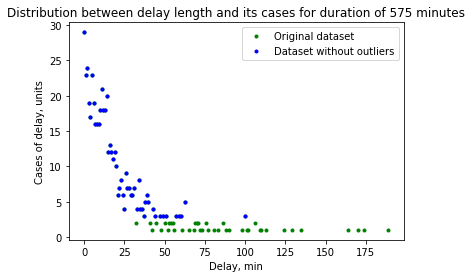

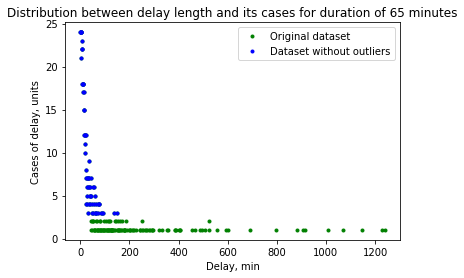

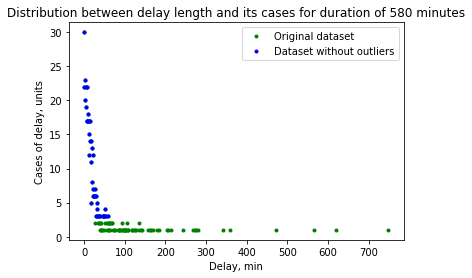

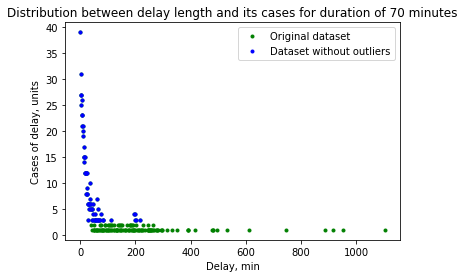

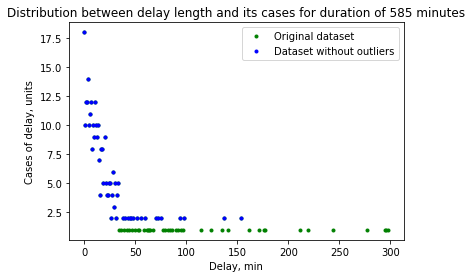

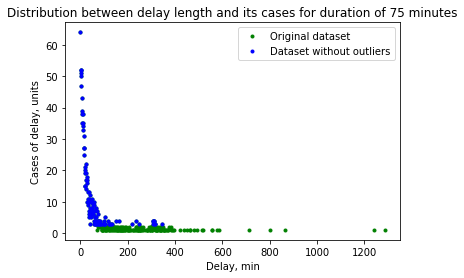

In [14]:
# Removal of outliers with respect to duration-delay dataset structure

d_idxs = np.array([])
cnt = 0
for i in list(set(f_train[:, -1])):
    delay, d_idx = l_train[np.where(f_train[:, -1] == i), :][0], np.where(f_train[:, -1] == i)
    delay = np.concatenate((delay, np.array(np.where(f_train[:, -1] == i)).transpose()), axis = 1)
    delays = []
    for j in list(set(delay[:, 0])):
        delays.append([j, np.count_nonzero(delay[:, 0] == j)])
    delays = np.array(delays)
    k = 1
    th = 0.1
    while k == 1:
        idx = np.where(delays[:, 1] / delays[:, 1].sum() > th)
        
        if delays[idx, 1].sum() / delays[:, 1].sum() < 0.8:
            th = th / 1.8
        
        else:
            k = 0
    
    if cnt < 20:
        plt.plot(delays[:, 0], delays[:, 1], '.', color = "green")
        plt.plot(delays[idx, 0], delays[idx, 1], '.', color = "blue")
        plt.title("Distribution between delay length and its cases for duration of " + str(int(i)) + " minutes")
        plt.xlabel("Delay, min")
        plt.ylabel("Cases of delay, units")
        plt.legend(['Original dataset', 'Dataset without outliers'])
        plt.show()
        cnt += 1
        
    idxs = []
    for j in range(len(delay[:, 0])):
        if delay[j, 0] in delays[idx, 0][0]:
            idxs.append(j)
    d_idx = np.array(delay[idxs, 1], dtype = int)
    d_idxs = np.concatenate((d_idxs, d_idx), axis = 0)

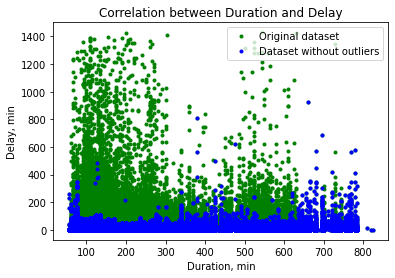

In [15]:
# Plot the dataset without outliers with respect to the initial dataset for duration feature

plt.plot(f_train[:, -1], l_train, '.', color = "green")
plt.plot(f_train[np.array(d_idxs, dtype = int), -1], l_train[np.array(d_idxs, dtype = int)], '.', color = "blue")
plt.title("Correlation between Duration and Delay")
plt.xlabel("Duration, min")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers'])
plt.show()

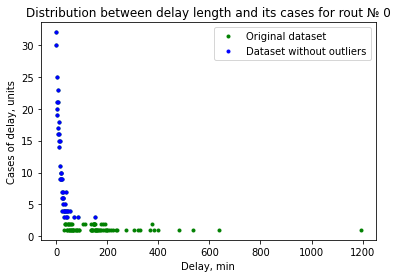

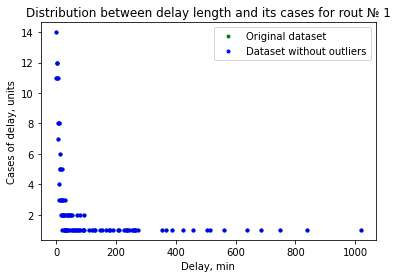

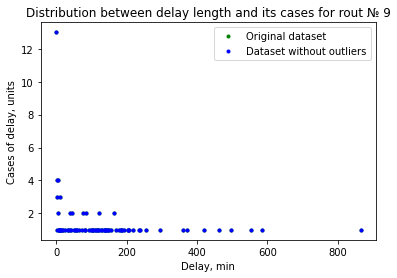

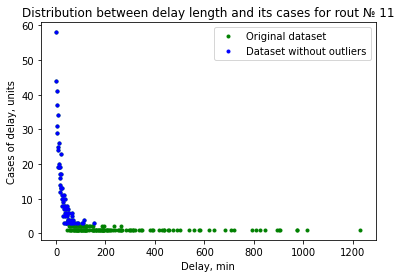

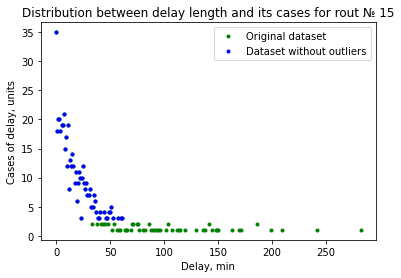

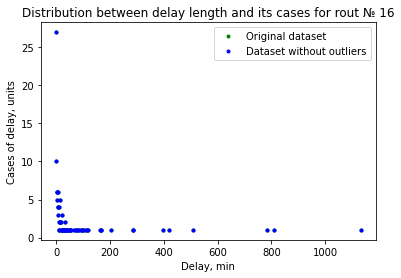

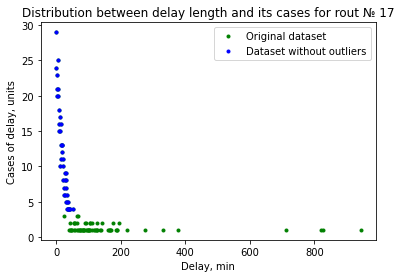

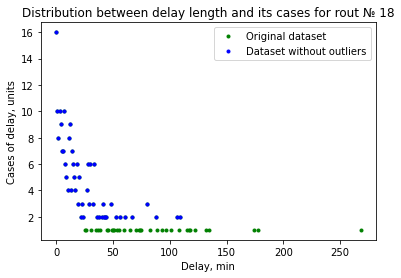

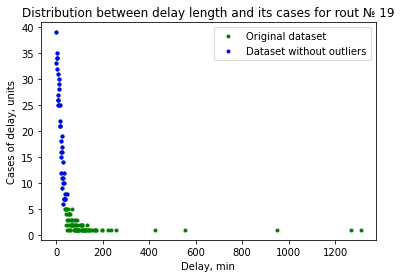

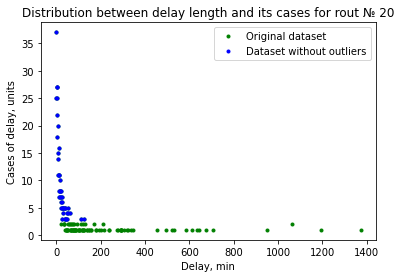

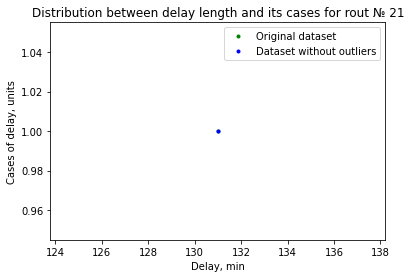

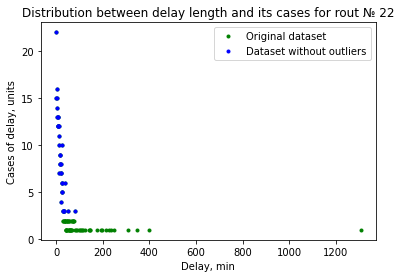

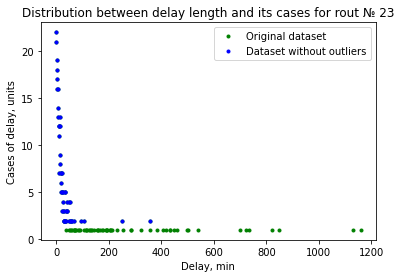

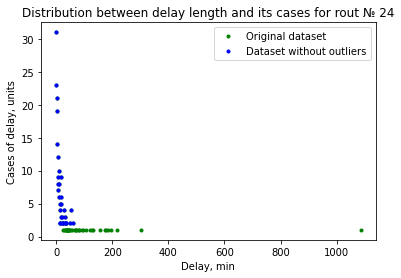

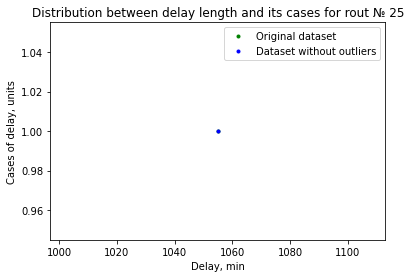

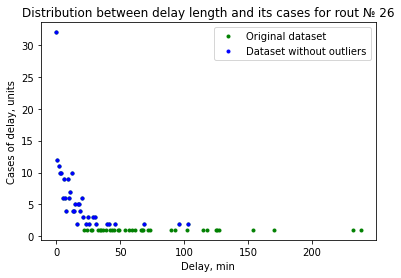

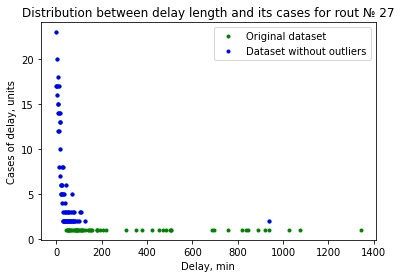

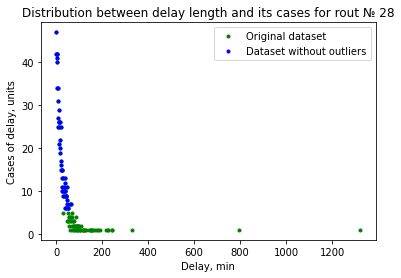

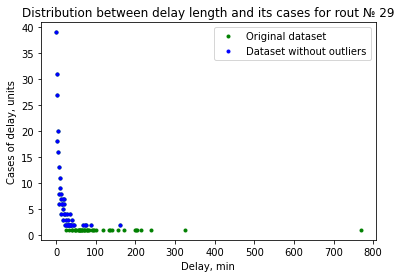

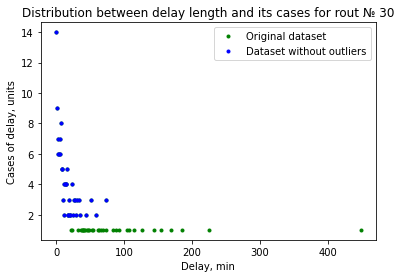

In [16]:
# Removal of outliers with respect to rout-delay dataset structure

p_idxs = np.array([])
cnt = 0
for i in list(set(p_train[:, 0])):
    delay, p_idx = l_train[np.where(p_train[:, 0] == i), :][0], np.where(p_train[:, 0] == i)
    delay = np.concatenate((delay, np.array(np.where(p_train[:, 0] == i)).transpose()), axis = 1)
    delays = []
    for j in list(set(delay[:, 0])):
        delays.append([j, np.count_nonzero(delay[:, 0] == j)])
    delays = np.array(delays)
    k = 1
    th = 0.1
    while k == 1:
        idx = np.where(delays[:, 1] / delays[:, 1].sum() > th)
        
        if delays[idx, 1].sum() / delays[:, 1].sum() < 0.8:
            th = th / 1.8
        
        else:
            k = 0
    
    if cnt < 20:
        plt.plot(delays[:, 0], delays[:, 1], '.', color = "green")
        plt.plot(delays[idx, 0], delays[idx, 1], '.', color = "blue")
        plt.title("Distribution between delay length and its cases for rout № " + str(i))
        plt.xlabel("Delay, min")
        plt.ylabel("Cases of delay, units")
        plt.legend(['Original dataset', 'Dataset without outliers'])
        plt.show()
        cnt += 1
    
    idxs = []
    for j in range(len(delay[:, 0])):
        if delay[j, 0] in delays[idx, 0][0]:
            idxs.append(j)
    p_idx = np.array(delay[idxs, 1], dtype = int)
    p_idxs = np.concatenate((p_idxs, p_idx), axis = 0)

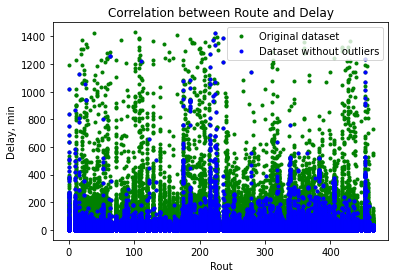

In [17]:
# Plot the dataset without outliers with respect to the initial dataset for rout feature

plt.plot(p_train, l_train, '.', color = "green")
plt.plot(p_train[np.array(p_idxs, dtype = int)], l_train[np.array(p_idxs, dtype = int)], '.', color = "blue")
plt.title("Correlation between Route and Delay")
plt.xlabel("Rout")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers'])
plt.show()

In [18]:
# Creation of indices dataset, that contains non-outlier data indices which are common for all three chosen features

indexes = np.array(np.intersect1d(m_idxs, d_idxs), dtype = int)
indexes = np.array(np.intersect1d(indexes, p_idxs), dtype = int)

In [19]:
# Creation of train datasets without outliers

f_train_c = f_train[indexes]
l_train_c = l_train[indexes]
m_train_c = m_train[indexes]
p_train_c = p_train[indexes]
print(str(int(len(f_train_c) / len(f_train) * 100)) + '% of data left')

77% of data left


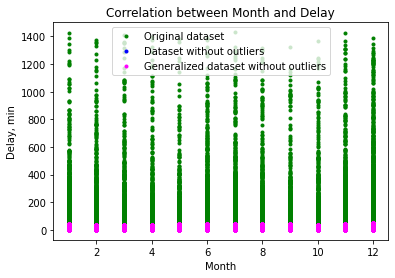

In [20]:
# Plotting of all stages of outliers removal with respect to month feature

plt.plot(m_train, l_train, '.', color = "green")
plt.plot(m_train[np.array(m_idxs, dtype = int)], l_train[np.array(m_idxs, dtype = int)], '.', color = "blue")
plt.plot(m_train_c, l_train_c, '.', color = "magenta")
plt.title("Correlation between Month and Delay")
plt.xlabel("Month")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers', 'Generalized dataset without outliers'])
plt.show()

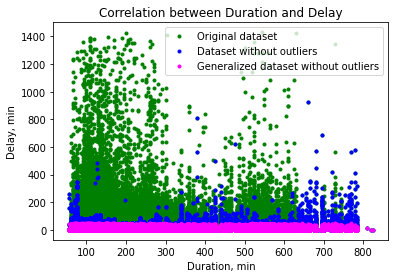

In [21]:
# Plotting of all stages of outliers removal with respect to duration feature

plt.plot(f_train[:, -1], l_train, '.', color = "green")
plt.plot(f_train[np.array(d_idxs, dtype = int), -1], l_train[np.array(d_idxs, dtype = int)], '.', color = "blue")
plt.plot(f_train_c[:, -1], l_train_c, '.', color = "magenta")
plt.title("Correlation between Duration and Delay")
plt.xlabel("Duration, min")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers', 'Generalized dataset without outliers'])
plt.show()

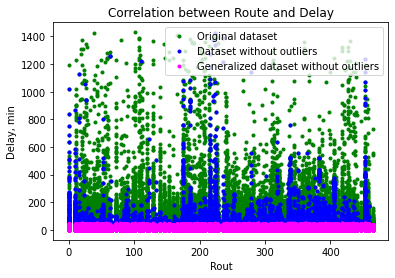

In [22]:
# Plotting of all stages of outliers removal with respect to path (rout) feature

plt.plot(p_train, l_train, '.', color = "green")
plt.plot(p_train[np.array(p_idxs, dtype = int)], l_train[np.array(p_idxs, dtype = int)], '.', color = "blue")
plt.plot(p_train_c, l_train_c, '.', color = "magenta")
plt.title("Correlation between Route and Delay")
plt.xlabel("Rout")
plt.ylabel("Delay, min")
plt.legend(['Original dataset', 'Dataset without outliers', 'Generalized dataset without outliers'])
plt.show()

In [23]:
# Initialization of Linear Regression model and its performance representation in terms of train and test datasets

L_R = LinearRegression().fit(f_train_c, l_train_c)
train_pred = L_R.predict(f_train_c)
test_pred = L_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 35.555 mins
Mean absolute error: 8.214 mins
Root mean squared error: 10.117 mins
Regression score r2: 0.004


Test
Maximum residual error: 1424.51 mins
Mean absolute error: 14.865 mins
Root mean squared error: 40.364 mins
Regression score r2: -0.017


In [24]:
# Initialization of Polynomial Regression model and its performance representation in terms of train and test datasets

P_R = Pipeline([("polynomial_features", PolynomialFeatures(degree = 3)), ("linear_regression", LinearRegression())])
P_R.fit(f_train_c, l_train_c)
train_pred = P_R.predict(f_train_c)
test_pred = P_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 36.914 mins
Mean absolute error: 8.137 mins
Root mean squared error: 10.039 mins
Regression score r2: 0.019


Test
Maximum residual error: 1422.448 mins
Mean absolute error: 14.506 mins
Root mean squared error: 40.236 mins
Regression score r2: -0.01


In [25]:
# A piece of code borrowed from lab 4 to determine the most suitable value of alpha parameter for Lasso regularization

alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
losses = []
for alpha in alphas:
    Lasso_R = Lasso(alpha = alpha).fit(f_train_c, l_train_c)
    pred = Lasso_R.predict(f_test)
    losses.append(metrics.mean_squared_error(l_test, pred))

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha for Lasso Regression model: ", best_alpha)

Best value of alpha for Lasso Regression model:  0.1


In [26]:
# Initialization of Linear Regression model with Lasso regularization and its performance representation in terms of 
# train and test datasets

Lasso_R = Lasso(alpha = best_alpha).fit(f_train_c, l_train_c)
train_pred = Lasso_R.predict(f_train_c)
test_pred = Lasso_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 35.591 mins
Mean absolute error: 8.214 mins
Root mean squared error: 10.117 mins
Regression score r2: 0.004


Test
Maximum residual error: 1424.465 mins
Mean absolute error: 14.878 mins
Root mean squared error: 40.365 mins
Regression score r2: -0.017


In [27]:
# Initialization of Polynomial Regression model with Lasso regularization and its performance representation in terms of 
# train and test datasets

PL_R = Pipeline([("polynomial_features", PolynomialFeatures(degree = 3)), ("linear_regression", Lasso(alpha = best_alpha))])
PL_R.fit(f_train_c, l_train_c)
train_pred = PL_R.predict(f_train_c)
test_pred = PL_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 37.383 mins
Mean absolute error: 8.141 mins
Root mean squared error: 10.045 mins
Regression score r2: 0.018


Test
Maximum residual error: 1423.381 mins
Mean absolute error: 14.586 mins
Root mean squared error: 40.26 mins
Regression score r2: -0.011


C:\Users\72684\Anaconda3\envs\chemie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5057247.878409238, tolerance: 1029.753081112627
  positive)


In [28]:
# A piece of code borrowed from lab 4 to determine the most suitable value of alpha parameter for Ridge regularization

alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
losses = []
for alpha in alphas:
    Ridge_R = Ridge(alpha = alpha).fit(f_train_c, l_train_c)
    pred = Ridge_R.predict(f_test)
    losses.append(metrics.mean_squared_error(l_test, pred))

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha for Ridge Regression model: ", best_alpha)

Best value of alpha for Ridge Regression model:  0.1


In [29]:
# Initialization of Linear Regression model with Ridge regularization and its performance representation in terms of 
# train and test datasets

Ridge_R = Ridge(alpha = best_alpha).fit(f_train_c, l_train_c)
train_pred = Ridge_R.predict(f_train_c)
test_pred = Ridge_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 35.555 mins
Mean absolute error: 8.214 mins
Root mean squared error: 10.117 mins
Regression score r2: 0.004


Test
Maximum residual error: 1424.51 mins
Mean absolute error: 14.865 mins
Root mean squared error: 40.364 mins
Regression score r2: -0.017


In [30]:
# Initialization of Polynomial Regression model with Ridge regularization and its performance representation in terms of 
# train and test datasets

PR_R = Pipeline([("polynomial_features", PolynomialFeatures(degree = 3)), ("linear_regression", Ridge(alpha = best_alpha))])
PR_R.fit(f_train_c, l_train_c)
train_pred = PR_R.predict(f_train_c)
test_pred = PR_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 36.914 mins
Mean absolute error: 8.137 mins
Root mean squared error: 10.039 mins
Regression score r2: 0.019


Test
Maximum residual error: 1422.448 mins
Mean absolute error: 14.506 mins
Root mean squared error: 40.236 mins
Regression score r2: -0.01


C:\Users\72684\Anaconda3\envs\chemie\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.34395e-22): result may not be accurate.
  overwrite_a=True).T


In [31]:
# Initialization of Support Vectors Regression model and its performance representation in terms of train and test datasets

SV_R = LinearSVR(epsilon = 0.5, C = 1).fit(f_train_c, l_train_c[:, 0])
train_pred = SV_R.predict(f_train_c)
test_pred = SV_R.predict(f_test)

print('Train')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_train_c, train_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_train_c, train_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_train_c, train_pred)), 3)) + ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_train_c, train_pred), 3)))

print('\n')

print('Test')
print('Maximum residual error: ' + str(np.round(metrics.max_error(l_test, test_pred), 3)) + ' mins')
print('Mean absolute error: ' + str(np.round(metrics.mean_absolute_error(l_test, test_pred), 3)) + ' mins')
print('Root mean squared error: ' + str(np.round(np.sqrt(metrics.mean_squared_error(l_test, test_pred)), 3)) + \
      ' mins')
print('Regression score r2: ' + str(np.round(metrics.r2_score(l_test, test_pred), 3)))

Train
Maximum residual error: 34.965 mins
Mean absolute error: 11.154 mins
Root mean squared error: 12.889 mins
Regression score r2: -0.617


Test
Maximum residual error: 1421.95 mins
Mean absolute error: 20.878 mins
Root mean squared error: 42.112 mins
Regression score r2: -0.106


C:\Users\72684\Anaconda3\envs\chemie\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
# Train dataset analysis

print('Train dataset standard deviation: ' + str(np.round(np.std(l_train_c), 3)) + ' mins')
print('Train dataset variance: ' + str(np.round(np.var(l_train_c), 3)) + ' mins^2')
print('Train dataset mean: ' + str(np.round(np.mean(l_train_c), 3)) + ' mins')
print('Train dataset max value: ' + str(int(np.max(l_train_c))) + ' mins')
print('Percentage of train dataset values which are bigger, than the train dataset mean value: ' + \
      str(np.round(np.count_nonzero(l_train_c > np.mean(l_train_c)) / len(l_train_c) * 100, 3)))
print('Train dataset min value: ' + str(int(np.min(l_train_c))))
print('Percentage of train dataset values which are equal to the train dataset min value: ' + \
      str(np.round(np.count_nonzero(l_train_c == np.min(l_train_c)) / len(l_train_c) * 100, 3)))

Train dataset standard deviation: 10.136 mins
Train dataset variance: 102.738 mins^2
Train dataset mean: 11.705 mins
Train dataset max value: 47 mins
Percentage of train dataset values which are bigger, than the train dataset mean value: 41.286
Train dataset min value: 0
Percentage of train dataset values which are equal to the train dataset min value: 7.74


In [33]:
# Test dataset analysis

print('Test dataset standard deviation: ' + str(np.round(np.std(l_test), 3)) + ' mins')
print('Test dataset variance: ' + str(np.round(np.var(l_test), 3)) + ' mins^2')
print('Test dataset mean: ' + str(np.round(np.mean(l_test), 3)) + ' mins')
print('Test dataset max value: ' + str(int(np.max(l_test))) + ' mins')
print('Percentage of test dataset values which are bigger, than the test dataset mean value: ' + \
      str(np.round(np.count_nonzero(l_test > np.mean(l_test)) / len(l_test) * 100, 3)))
print('Test dataset min value: ' + str(int(np.min(l_test))))
print('Percentage of test dataset values which are equal to the test dataset min value: ' + \
      str(np.round(np.count_nonzero(l_test == np.min(l_test)) / len(l_test) * 100, 3)))

Test dataset standard deviation: 40.035 mins
Test dataset variance: 1602.772 mins^2
Test dataset mean: 6.474 mins
Test dataset max value: 1436 mins
Percentage of test dataset values which are bigger, than the test dataset mean value: 12.182
Test dataset min value: 0
Percentage of test dataset values which are equal to the test dataset min value: 79.606
